In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import zscore, f_oneway
from statsmodels.tsa.seasonal import seasonal_decompose
import os
import glob

In [16]:
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/finaldata/combined_coral_data.csv')


print("Data Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())


print("\nUnique Regions:", df['Source_File'].unique())
print("\nYear Range:", df['YYYY'].min(), "-", df['YYYY'].max())

Data Shape: (58701, 11)

First 5 rows:
       Source_File  YYYY  MM  DD  SST_MIN  SST_MAX  SST@90th_HS  SSTA@90th_HS  \
0  lakshadweep.txt  1985   1   1    27.84    28.11        28.10       -0.1555   
1  lakshadweep.txt  1985   1   2    27.83    28.10        28.07       -0.1658   
2  lakshadweep.txt  1985   1   3    27.89    28.19        28.11       -0.0413   
3  lakshadweep.txt  1985   1   4    28.02    28.31        28.30        0.1416   
4  lakshadweep.txt  1985   1   5    27.47    27.73        27.65       -0.4300   

   90th_HS>0  DHW_from_90th_HS>1  BAA_7day_max  
0        0.0                 0.0             0  
1        0.0                 0.0             0  
2        0.0                 0.0             0  
3        0.0                 0.0             0  
4        0.0                 0.0             0  

Columns: ['Source_File', 'YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max']

Data Types:
 Source_File     

In [13]:
# Numerical summary
print("Descriptive Stats:\n", df.describe(percentiles=[.25, .5, .75, .95]))

# Categorical summary
print("\nRegion Distribution:\n", df['Source_File'].value_counts())

Descriptive Stats:
               YYYY            MM            DD       SST_MIN       SST_MAX  \
count  58701.00000  58701.000000  58701.000000  58701.000000  58701.000000   
mean    2004.59217      6.501133     15.722713     27.306172     28.751543   
std       11.59830      3.456754      8.801064      2.028024      1.640296   
min     1985.00000      1.000000      1.000000     17.090000     21.400000   
25%     1995.00000      3.000000      8.000000     26.690000     28.250000   
50%     2005.00000      7.000000     16.000000     27.740000     28.980000   
75%     2015.00000     10.000000     23.000000     28.510000     29.700000   
95%     2023.00000     12.000000     29.000000     29.640000     30.880000   
max     2025.00000     12.000000     31.000000     31.730000     33.480000   

        SST@90th_HS  SSTA@90th_HS     90th_HS>0  DHW_from_90th_HS>1  \
count  58701.000000  58701.000000  58701.000000        58701.000000   
mean      28.481107      0.473656      0.099932          

Index(['Source_File', 'YYYY', 'MM', 'DD', 'SST_MIN', 'SST_MAX', 'SST@90th_HS',
       'SSTA@90th_HS', '90th_HS>0', 'DHW_from_90th_HS>1', 'BAA_7day_max'],
      dtype='object')


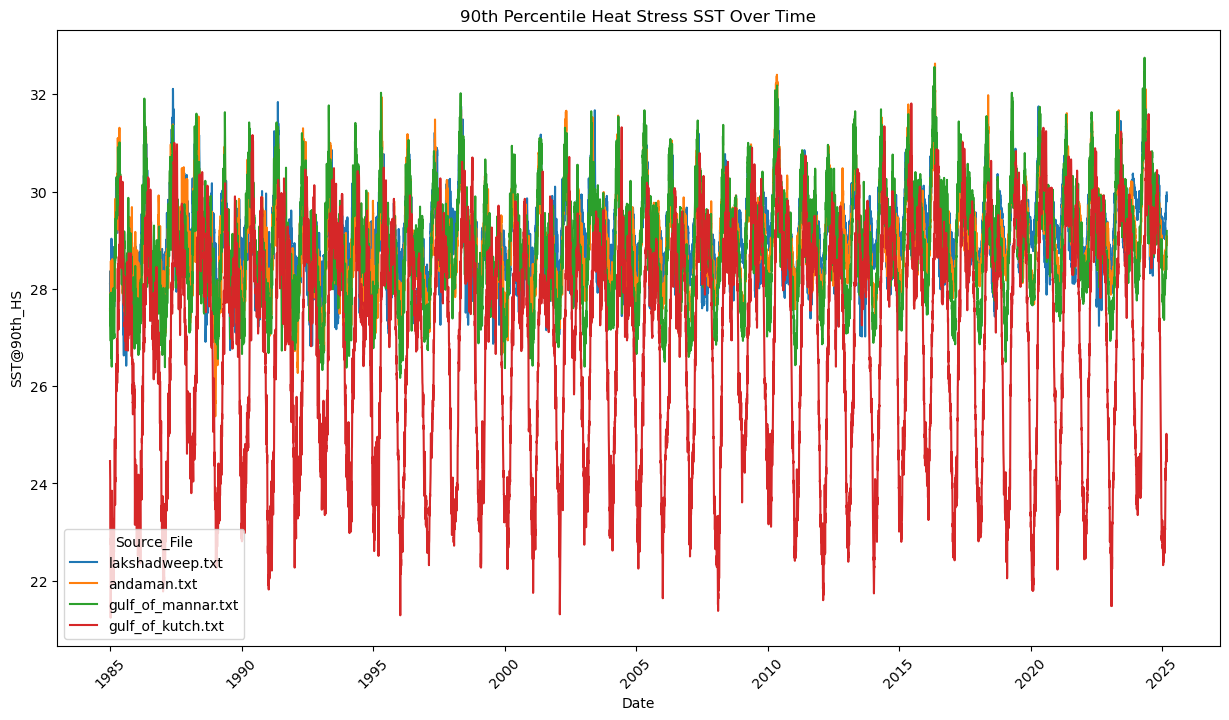

In [19]:
# First, make sure we're loading the CSV file correctly
df = pd.read_csv('/Users/owlxshri/Desktop/coral reef/mlpr-project/finaldata/combined_coral_data.csv')

# Check the columns in the DataFrame
print(df.columns)

# Ensure the date columns are integers (not strings)
df['YYYY'] = df['YYYY'].astype(int)
df['MM'] = df['MM'].astype(int)
df['DD'] = df['DD'].astype(int)

# Convert to datetime using the more direct approach
df['Date'] = pd.to_datetime(dict(year=df['YYYY'], month=df['MM'], day=df['DD']))

# Time series plot for SST metrics
plt.figure(figsize=(15,8))
sns.lineplot(x='Date', y='SST@90th_HS', hue='Source_File', data=df)
plt.title('90th Percentile Heat Stress SST Over Time')
plt.xticks(rotation=45)
plt.show()

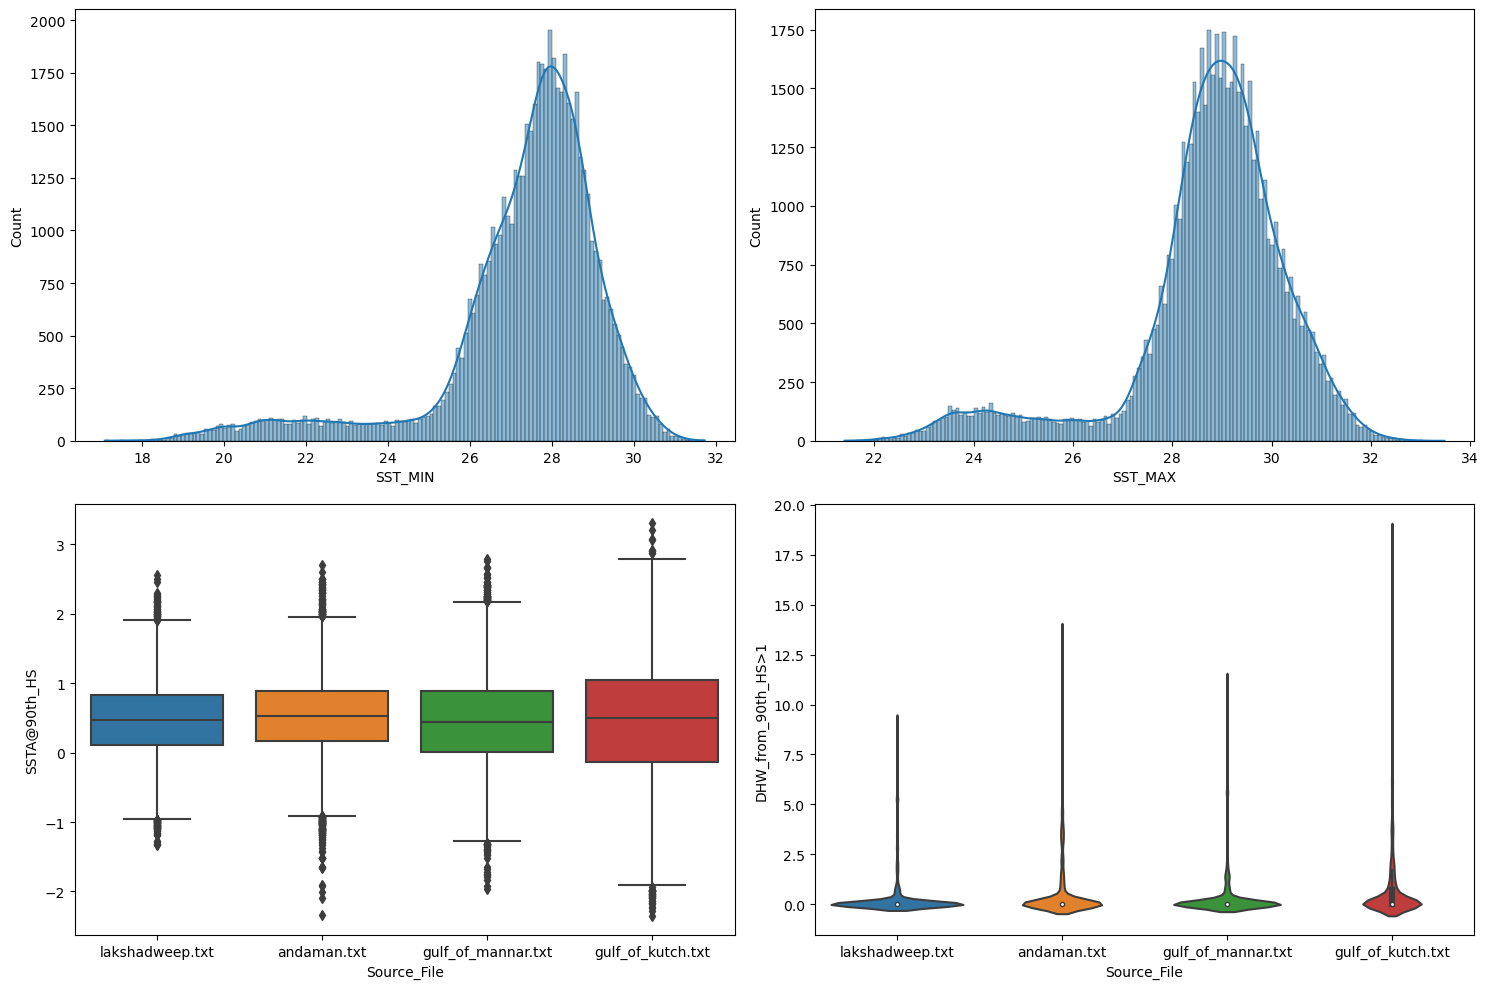

In [20]:
# Distribution of key variables
fig, axes = plt.subplots(2, 2, figsize=(15,10))
sns.histplot(df['SST_MIN'], kde=True, ax=axes[0,0])
sns.histplot(df['SST_MAX'], kde=True, ax=axes[0,1])
sns.boxplot(x='Source_File', y='SSTA@90th_HS', data=df, ax=axes[1,0])
sns.violinplot(x='Source_File', y='DHW_from_90th_HS>1', data=df, ax=axes[1,1])
plt.tight_layout()
plt.show()

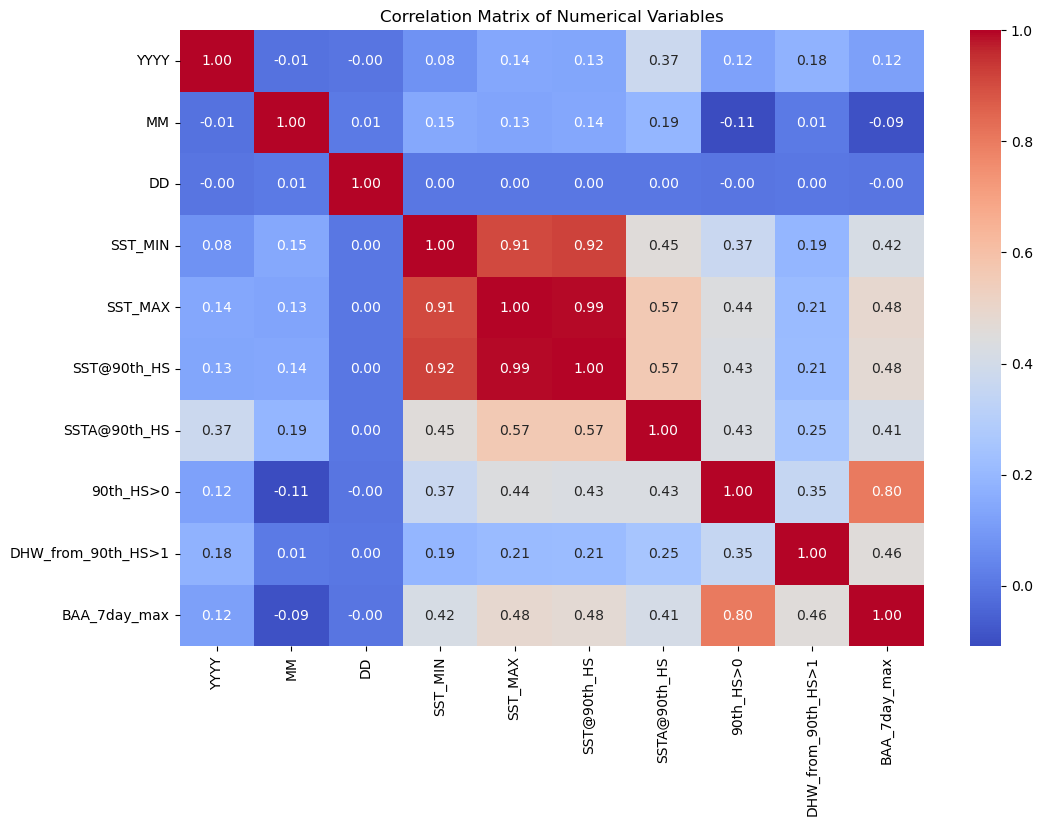

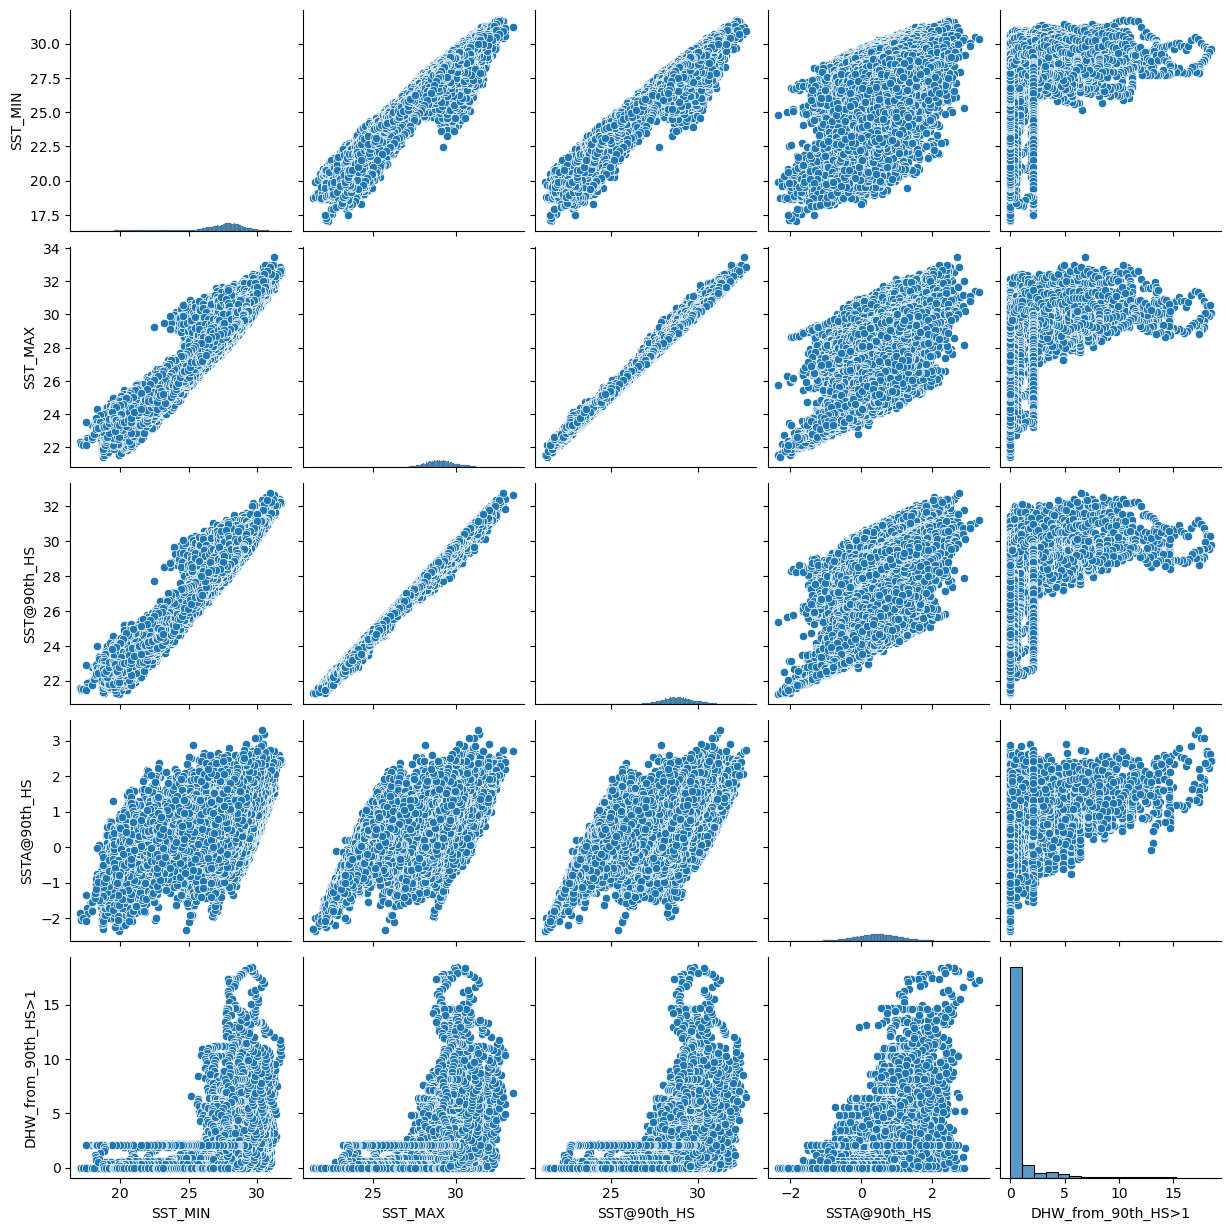

In [21]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=np.number).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Variables')
plt.show()

# Pairplot for key variables
sns.pairplot(df[['SST_MIN', 'SST_MAX', 'SST@90th_HS', 'SSTA@90th_HS', 'DHW_from_90th_HS>1']])
plt.show()

In [22]:
# Regional averages
regional_stats = df.groupby('Source_File').agg({
    'SST_MIN': ['mean', 'std'],
    'SST_MAX': ['mean', 'std'],
    'DHW_from_90th_HS>1': 'sum'
}).reset_index()
print("Regional Statistics:\n", regional_stats)

# ANOVA test for regional differences
from scipy.stats import f_oneway
groups = [group['SST@90th_HS'] for name, group in df.groupby('Source_File')]
f_stat, p_value = f_oneway(*groups)
print(f"\nANOVA p-value for SST@90th_HS: {p_value:.4f}")

Regional Statistics:
           Source_File    SST_MIN              SST_MAX            \
                            mean       std       mean       std   
0         andaman.txt  28.031982  1.025209  29.179497  0.928028   
1   gulf_of_kutch.txt  25.542405  2.898687  27.304000  2.259990   
2  gulf_of_mannar.txt  27.337562  1.239608  29.336897  1.112091   
3     lakshadweep.txt  28.312688  0.900232  29.185749  0.864594   

  DHW_from_90th_HS>1  
                 sum  
0          8616.8387  
1         12014.5093  
2          5324.6460  
3          4403.5146  

ANOVA p-value for SST@90th_HS: 0.0000


In [23]:
# Z-score analysis
numeric_cols = df.select_dtypes(include=np.number).columns
z_scores = df[numeric_cols].apply(zscore)
outliers = (np.abs(z_scores) > 3).sum()
print("Potential Outliers (z-score >3):\n", outliers)

# IQR method for SST_MIN
Q1 = df['SST_MIN'].quantile(0.25)
Q3 = df['SST_MIN'].quantile(0.75)
IQR = Q3 - Q1
print(f"\nSST_MIN Outliers (IQR): {((df['SST_MIN'] < (Q1 - 1.5 * IQR)) | (df['SST_MIN'] > (Q3 + 1.5 * IQR))).sum()}")

Potential Outliers (z-score >3):
 YYYY                     0
MM                       0
DD                       0
SST_MIN               1750
SST_MAX               1447
SST@90th_HS           1533
SSTA@90th_HS           261
90th_HS>0             1937
DHW_from_90th_HS>1    1494
BAA_7day_max           783
dtype: int64

SST_MIN Outliers (IQR): 4382


/var/folders/rh/12qqnf0d5871pn0c7924tqwc0000gn/T/ipykernel_25226/261663372.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_df = df.set_index('Date').resample('M').mean()


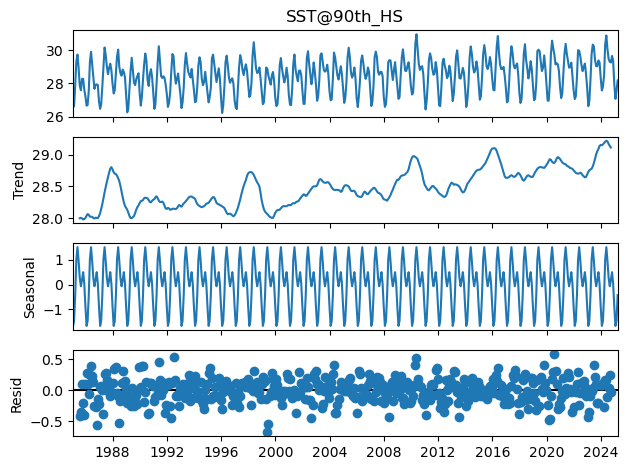

In [24]:
# Resample to monthly data
monthly_df = df.set_index('Date').resample('M').mean()

# Decomposition for SST@90th_HS
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(monthly_df['SST@90th_HS'], model='additive')
result.plot()
plt.show()

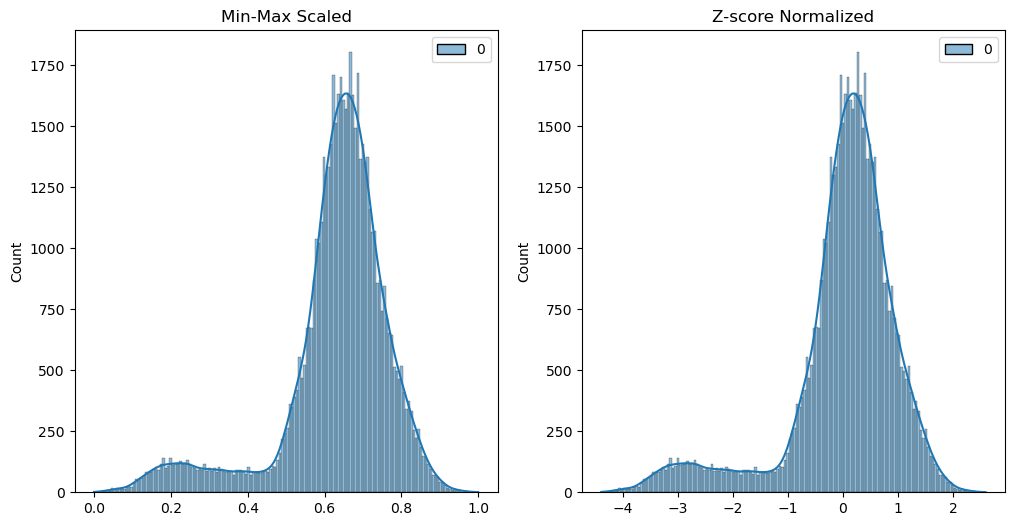

In [25]:
# Compare scaling methods
scaler = MinMaxScaler()
standard_scaler = StandardScaler()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(scaler.fit_transform(df[['SST@90th_HS']]), kde=True)
plt.title('Min-Max Scaled')

plt.subplot(1,2,2)
sns.histplot(standard_scaler.fit_transform(df[['SST@90th_HS']]), kde=True)
plt.title('Z-score Normalized')
plt.show()